In [42]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

/Users/ahsanmuhammad/OneDrive/Documents/github/natural-language-processing-uni-kiel-ss24/myenv/lib/python3.8/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Loading the DataSet
car_data = pd.read_csv("Car details v3.csv")

## Exploratory Data Analysis (Part a)

### Summarize & View Data

In [3]:
# Inspecting head of the data
car_data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [4]:
# Describing the data to view summary statistics
car_data.describe()

,year,selling_price,km_driven,seats
count,8128.000000,8.128000e+03,8.128000e+03,7907.000000
mean,2013.804011,6.382718e+05,6.981951e+04,5.416719
std,4.044249,8.062534e+05,5.655055e+04,0.959588
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.800000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


In [5]:
## Helper Functions

# Custom function to clean and convert engine and max power columns
def clean_and_convert(value):
    if isinstance(value, str):
        # Remove ' CC' or ' bhp', strip any leading/trailing whitespace 
        value = value.replace(' CC', '').replace(' bhp', '').strip()
        if value:
            return float(value)
        else:
            # Return None or any appropriate value for empty strings
            return None
    else:
        # Return the original value if not a string
        return value

# Custom function to clean torque, mileage value
def extract_value(torque_str):
    # Regular expression pattern to extract numeric values
    pattern = r'(\d+(\.\d+)?)'
    
    # Find all numeric values in the torque string
    values = re.findall(pattern, torque_str)
    
    if values:
        return float(values[0][0])
    else:
        # Return None if no numeric value is found
        return None 


In [6]:
# treating mileage, engine,	max_power as numerical values - converting to floats
car_data['engine']    = car_data['engine'].apply(clean_and_convert)
car_data['max_power'] = car_data['max_power'].apply(clean_and_convert)
car_data['torque']    = car_data['torque'].astype(str).apply(extract_value)
car_data['mileage']   = car_data['mileage'].astype(str).apply(extract_value)

In [7]:
# Checking the new data after making it useful for ML model
car_data.head(2)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190.0,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250.0,5.0


In [8]:
# Check for missing values of the data
missing_values = car_data.isna().sum()

# Display columns with missing values and their counts
missing_data = missing_values[missing_values > 0]
if not missing_data.empty:
    print("Columns with Missing Values:")
    print(missing_data)
else:
    print("No Missing Data. Go Ahead with your analysis")

# Only 2.5% of the total data missing - Just drop them

Columns with Missing Values:
mileage      221
engine       221
max_power    216
torque       222
seats        221
dtype: int64


In [9]:
# dropping na data points
car_data.dropna(inplace=True)

### Outlier Analysis via BoxPlot

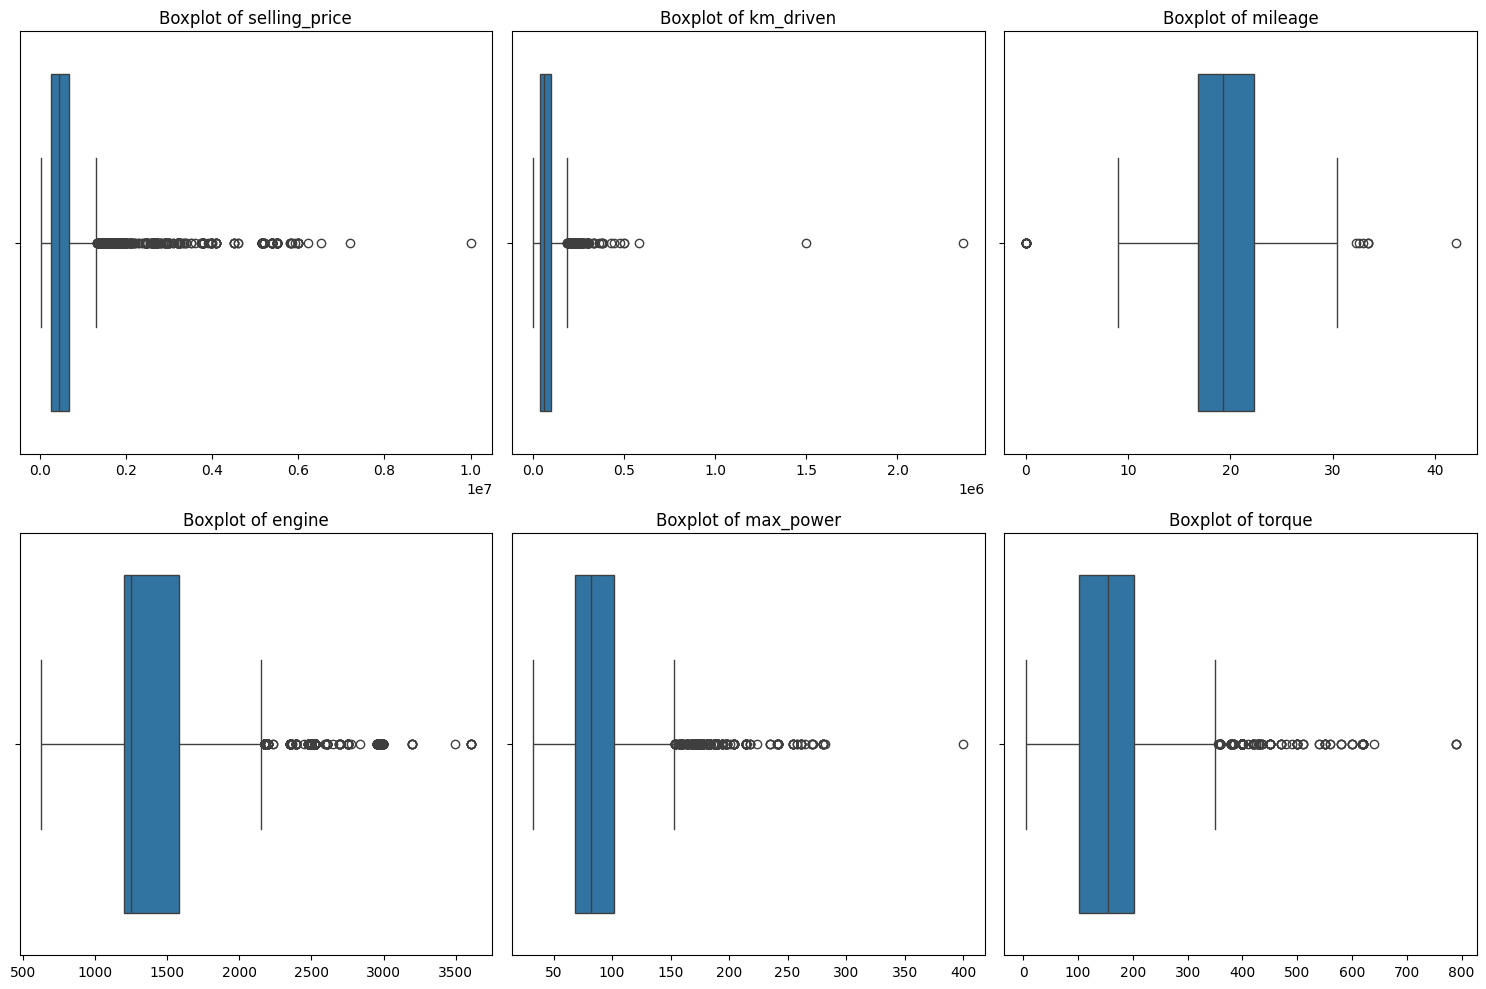

In [11]:
# Define the columns for boxplot visualization
columns = ['selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque']

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over each column and create a boxplot
for i, column in enumerate(columns):
    sns.boxplot(x=car_data[column], ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')
    axes[i].set_xlabel('')  # Clear x-axis label for better visualization

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Checking some Outlier Values in Detail

In [13]:
# most expensive car
car_data[car_data['selling_price']> 8000000]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
170,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0,1969.0,400.0,640.0,4.0


In [14]:
# makes sense - good features and max price
car_data[car_data['mileage'] > 40]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
170,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0,1969.0,400.0,640.0,4.0


In [15]:
# doubtful for old cars to record 0 mileage - got to consult the car companies. For now, we just drop these due to small sample size
car_data[car_data['mileage'] == 0]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
644,Tata Indica Vista Aura Safire Anniversary Edition,2009,135000,28900,Petrol,Individual,Manual,Second Owner,0.0,1172.0,65.00,9.8,5.0
785,Hyundai Santro Xing GL,2009,120000,90000,Petrol,Individual,Manual,Second Owner,0.0,1086.0,62.00,96.1,5.0
1649,Hyundai Santro Xing GL,2008,105000,128000,Petrol,Individual,Manual,First Owner,0.0,1086.0,62.00,96.1,5.0
1676,Mercedes-Benz M-Class ML 350 4Matic,2011,1700000,110000,Diesel,Individual,Automatic,Third Owner,0.0,2987.0,165.00,510.0,5.0
2137,Land Rover Freelander 2 TD4 HSE,2013,1650000,64788,Diesel,Dealer,Automatic,First Owner,0.0,2179.0,115.00,400.0,5.0
2366,Hyundai Santro Xing (Non-AC),2010,110000,80000,Petrol,Individual,Manual,Second Owner,0.0,1086.0,62.10,96.1,5.0
2725,Hyundai Santro Xing (Non-AC),2013,184000,15000,Petrol,Individual,Manual,First Owner,0.0,1086.0,62.10,96.1,5.0
4527,Mercedes-Benz M-Class ML 350 4Matic,2011,1700000,110000,Diesel,Individual,Automatic,Third Owner,0.0,2987.0,165.00,510.0,5.0
5276,Hyundai Santro Xing GL,2008,175000,40000,Petrol,Individual,Manual,First Owner,0.0,1086.0,62.00,96.1,5.0
5843,Volkswagen Polo GT TSI BSIV,2014,574000,28080,Petrol,Dealer,Automatic,First Owner,0.0,1197.0,103.25,175.0,5.0


In [16]:
## drop Datapoints where mileage = 0 
car_data = car_data[car_data['mileage'] != 0]

In [17]:
# old car with outlier km_driven
car_data[car_data['km_driven'] > 1500000]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
3486,Hyundai i20 Asta 1.2,2007,550000,2360457,Petrol,Individual,Manual,Second Owner,18.6,1197.0,81.83,114.7,5.0


In [18]:
### Conclusion on Outliers: It looks good. Selling Price high for expensive vehicles; Present Value high for expensive and less driven vehicles; KMS high for older vehicles

### Data Normalisation - For numerical columns

In [20]:
numeric_columns = ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats']

X = car_data.drop('selling_price', axis=1)
y = car_data['selling_price']

# Initialize and fit the MinMaxScaler on the feature variables
scaler = MinMaxScaler()
X[numeric_columns] = scaler.fit_transform(X[numeric_columns])

# Fit and transform the target variable (Selling_Price)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

### One-Hot Encoding - For categorical columns

In [22]:
# Assuming 'car_data' is your DataFrame containing the dataset
categorical_cols = ['name', 'fuel', 'seller_type', 'transmission', 'owner', 'seats']

# Perform one-hot encoding on categorical columns
encoded_data = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [23]:
# Inspect the data after normalisation and one-hot encoding

In [24]:
encoded_data.head()

,year,km_driven,mileage,engine,max_power,torque,name_Ambassador Classic 2000 DSZ AC PS,name_Ambassador Grand 1500 DSZ BSIII,name_Ambassador Grand 2000 DSZ PW CL,name_Ashok Leyland Stile LE,...,owner_Second Owner,owner_Test Drive Car,owner_Third Owner,seats_0.09999999999999998,seats_0.20000000000000007,seats_0.30000000000000004,seats_0.4,seats_0.5,seats_0.6,seats_1.0
0,0.769231,0.061640,0.436364,0.209396,0.112200,0.236164,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,0.769231,0.050837,0.367879,0.293289,0.192593,0.312675,False,False,False,False,...,True,False,False,True,False,False,False,False,False,False
2,0.461538,0.059310,0.263636,0.292953,0.123094,0.010074,False,False,False,False,...,False,False,True,True,False,False,False,False,False,False
3,0.615385,0.053803,0.424242,0.259060,0.155773,0.022443,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,0.500000,0.050837,0.215152,0.226174,0.150871,0.008544,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


## Data Split (Part B)

In [25]:
# Extract features (X) and target (y)
X = encoded_data
y = y_scaled

In [26]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Print the sizes of the training and testing sets
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of testing samples: {X_test.shape[0]}")

# Assuming X_train and X_test are your input feature arrays
X_train = X_train.astype('float32')  # Convert to float32
X_test = X_test.astype('float32')    # Convert to float32

Number of training samples: 1577
Number of testing samples: 6312


## Model Designing and Training (Part C)

In [27]:
# A basic network with input layer of 64 neurons with relu activation (numerical Y); hidden layer of 32 neurons with relu activation; and single output later

In [28]:
# setting input shape
# Assuming X_train and y_train are your training features and labels
input_shape = X_train.shape[1:]  # Input shape based on number of features

In [46]:
# flexible nn model creation function - also allows for regularlisation with a flag
def create_feedforward_nn(input_shape, 
                          num_hidden_layers=2, 
                          hidden_layer_units=[64, 32], 
                          activations='relu',
                          learning_rate=0.01, 
                          batch_size=32,
                          loss='mse', 
                          optimizer='adam',
                          metrics=['mae'],
                          regularization=False,
                          dropout_rate=0.2,
                          l2_penalty=0.001):
    
    model = keras.Sequential()
    
    # Adding input layer
    model.add(layers.Dense(hidden_layer_units[0], 
                           input_shape=input_shape, 
                           activation=activations))
    
    # Adding hidden layers with optional regularization and dropout
    for i in range(1, num_hidden_layers):
        # Add hidden layer with optional L2 regularization
        model.add(layers.Dense(hidden_layer_units[i], 
                               activation=activations,
                               kernel_regularizer=l2(l2_penalty) if regularization else None))
        # Add dropout layer if regularization is enabled
        if regularization:
            model.add(layers.Dropout(dropout_rate))
    
    # Adding output layer
    model.add(layers.Dense(1))  # Output layer for regression (single output neuron)

    # Create optimizer object based on the specified optimizer string
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
        
    # Compile the model
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=metrics
    )
    
    return model

### Run Model, Summarize & Evaluate

In [31]:
# Define custom parameters
custom_params = {
    'num_hidden_layers': 3,
    'hidden_layer_units': [64, 32, 16],
    'activations': 'relu',
    'learning_rate': 0.001,
    'batch_size': 64,
    'loss': 'mse',
    'optimizer': 'adam',
    'metrics': ['mae']
}

# Create the custom feedforward neural network model
model = create_feedforward_nn(input_shape=input_shape, **custom_params)

# Display the model architecture
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,            # Number of epochs
    batch_size=32,        # Batch size
    validation_split=0.2  # Validation split for monitoring validation performance during training
)

# Evaluate the model on test data
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Mean Absolute Error: {mae:.2f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                127744    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 130,369
Trainable params: 130,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40/40 [==============================] - 3s 22ms/step - loss: 0.0061 - mae: 0.0391 - val_loss: 0.0028 - val_mae: 0.0287
Epoch 2/50
40/40 [==============================] -

## Hyper parameter tuning & Model Evaluation

In [32]:
# helpful function to fit model and evaluate
def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, verbose=0):
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=verbose
    )
    
    # Evaluate the model on test data
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Test Mean Absolute Error: {mae:.2f}")
    
    # Make predictions using the trained model
    y_pred = model.predict(X_test)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    return loss, mae, rmse

In [33]:
# Define hyperparameter settings to test
learning_rates = [0.001, 0.01, 0.1]
batch_sizes    = [16, 32, 64]
epochs         = [100, 200, 300]

In [34]:
# Create a list to store evaluation results for different hyperparameter settings
evaluation_results = []

# Iterate over all combinations of hyperparameters
for lr in learning_rates:
    for bs in batch_sizes:
        for ep in epochs:
            print(f"Training with learning rate={lr}, batch size={bs}, epochs={ep}")
            
            # Create and compile the model using custom hyperparameters
            custom_params = {
                'learning_rate': lr,
                'batch_size'   : bs,
                'loss'         : 'mse',
                'optimizer'    : 'adam',  # Using Adam optimizer
                'metrics'      : ['mae']
            }
            model = create_feedforward_nn(input_shape=X_train.shape[1:], **custom_params)
            
            # Train the model
            history = model.fit(
                X_train, y_train,
                epochs=ep,
                batch_size=bs,
                validation_split=0.2,
                verbose=0  # Set verbose to 0 to suppress training output
            )
            
            # Evaluate the model on test data
            loss, mae = model.evaluate(X_test, y_test, verbose=0)
            
            # Store evaluation results
            evaluation_results.append({
                'learning_rate': lr,
                'batch_size': bs,
                'epochs': ep,
                'mse': loss,
                'mae': mae
            })
            
            print(f"Test Mean Absolute Error: {mae:.2f}, Test Mean Squared Error: {loss:.2f}")
            print()

# Find the best hyperparameter setting based on minimum MAE
best_result = min(evaluation_results, key=lambda x: x['mae'])

print("Best hyperparameter setting:")
print(best_result)

Training with learning rate=0.001, batch size=16, epochs=100
Test Mean Absolute Error: 0.01, Test Mean Squared Error: 0.00

Training with learning rate=0.001, batch size=16, epochs=200
Test Mean Absolute Error: 0.02, Test Mean Squared Error: 0.00

Training with learning rate=0.001, batch size=16, epochs=300
Test Mean Absolute Error: 0.02, Test Mean Squared Error: 0.00

Training with learning rate=0.001, batch size=32, epochs=100
Test Mean Absolute Error: 0.02, Test Mean Squared Error: 0.00

Training with learning rate=0.001, batch size=32, epochs=200
Test Mean Absolute Error: 0.02, Test Mean Squared Error: 0.00

Training with learning rate=0.001, batch size=32, epochs=300
Test Mean Absolute Error: 0.02, Test Mean Squared Error: 0.00

Training with learning rate=0.001, batch size=64, epochs=100
Test Mean Absolute Error: 0.02, Test Mean Squared Error: 0.00

Training with learning rate=0.001, batch size=64, epochs=200
Test Mean Absolute Error: 0.02, Test Mean Squared Error: 0.00

Training

### Train Model with Best Setting and Evaluate

In [36]:
# extracting best result parameters
lr = best_result['learning_rate']
br = best_result['batch_size']
ep = best_result['epochs']

# Create and compile the model using custom hyperparameters
custom_params = {
    'learning_rate': lr,
    'batch_size'   : bs,
    'loss'         : 'mse',
    'optimizer'    : 'adam',  # Using Adam optimizer
    'metrics'      : ['mae']
}

# create the model with the best config
model = create_feedforward_nn(input_shape=X_train.shape[1:], **custom_params)

# fit model and print result evaluation
fit_and_evaluate_model(model, X_train, y_train, X_test, y_test, ep, bs, verbose=0)

198/198 [==============================] - 0s 2ms/step - loss: 0.0011 - mae: 0.0162
Test Mean Absolute Error: 0.02
198/198 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 0.02
Root Mean Squared Error (RMSE): 0.03


(0.0010743129532784224, 0.016236189650727657, 0.03277670978206296)

## Fine-tuning and Optimization with Different Architecture (Part E)

In [38]:
# defining different architectures
# Define different architectures to try
architecture_configs = [
    {
        'num_hidden_layers': 2,
        'hidden_layer_units': [64, 32],
        'activations': 'relu',
        'learning_rate': lr
    },
    {
        'num_hidden_layers': 2,
        'hidden_layer_units': [64, 32],
        'activations': 'tanh',
        'learning_rate': lr
    },
    
    {
        'num_hidden_layers': 3,
        'hidden_layer_units': [128, 64, 32],
        'activations': 'relu',
        'learning_rate': lr
    },
    {
        'num_hidden_layers': 3,
        'hidden_layer_units': [128, 64, 32],
        'activations': 'tanh',
        'learning_rate': lr
    },

    {
        'num_hidden_layers': 3,
        'hidden_layer_units': [64, 64, 64],
        'activations': 'relu',
        'learning_rate': lr
    },
    {
        'num_hidden_layers': 3,
        'hidden_layer_units': [64, 64, 64],
        'activations': 'tanh',
        'learning_rate': lr
    },

    {
        'num_hidden_layers': 4,
        'hidden_layer_units': [64, 64, 32, 32],
        'activations': 'relu',
        'learning_rate': lr
    },
    {
        'num_hidden_layers': 4,
        'hidden_layer_units': [64, 64, 32, 32],
        'activations': 'tanh',
        'learning_rate': lr
    },
]

In [39]:
results = []

# Iterate over each architecture configuration
for idx, config in enumerate(architecture_configs):
    print(f"Running experiment {idx + 1}/{len(architecture_configs)} with configuration: {config}")
    
    # Create and compile the model
    model = create_feedforward_nn(input_shape=input_shape, **config)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=ep,            # Number of epochs
        batch_size=br,         # Batch size
        validation_split=0.2,  # Validation split for monitoring validation performance during training
        verbose=0
    )
    
    # Evaluate the model on test data
    loss, mae = model.evaluate(X_test, y_test)
    print(f"Test Mean Absolute Error: {mae:.2f}")
    
    # Store the results (architecture configuration and evaluation metrics)
    results.append({
        'configuration': config,
        'loss': loss,
        'mae': mae
    })

# Find the best configuration based on Mean Absolute Error (MAE)
best_config = min(results, key=lambda x: x['mae'])
print(f"\nBest Configuration (based on MAE): {best_config['configuration']}")
print(f"Test MAE: {best_config['mae']:.2f}")

Running experiment 1/8 with configuration: {'num_hidden_layers': 2, 'hidden_layer_units': [64, 32], 'activations': 'relu', 'learning_rate': 0.01}
198/198 [==============================] - 1s 3ms/step - loss: 0.0011 - mae: 0.0166
Test Mean Absolute Error: 0.02
Running experiment 2/8 with configuration: {'num_hidden_layers': 2, 'hidden_layer_units': [64, 32], 'activations': 'tanh', 'learning_rate': 0.01}
198/198 [==============================] - 1s 6ms/step - loss: 5.8611e-04 - mae: 0.0142
Test Mean Absolute Error: 0.01
Running experiment 3/8 with configuration: {'num_hidden_layers': 3, 'hidden_layer_units': [128, 64, 32], 'activations': 'relu', 'learning_rate': 0.01}
198/198 [==============================] - 1s 3ms/step - loss: 9.2365e-04 - mae: 0.0161
Test Mean Absolute Error: 0.02
Running experiment 4/8 with configuration: {'num_hidden_layers': 3, 'hidden_layer_units': [128, 64, 32], 'activations': 'tanh', 'learning_rate': 0.01}
198/198 [==============================] - 1s 3ms/ste

In [40]:
config = best_config['configuration']
# extracting the best parameters
num_hidden_layers  = config['num_hidden_layers']
hidden_layer_units = config['hidden_layer_units']
activation         = config['activations']

In [41]:
# Define custom parameters
custom_params = {
    'num_hidden_layers': num_hidden_layers,
    'hidden_layer_units': hidden_layer_units,
    'activations': activation,
    'learning_rate': lr,
    'batch_size': br,
    'loss': 'mse',
    'optimizer': 'adam',
    'metrics': ['mae']
}

# Create the custom feedforward neural network model with the best config of architecture
model = create_feedforward_nn(input_shape=input_shape, **custom_params)

### Test With Regularisation - Avoid Overfitting

In [47]:
# Define custom parameters - set regularisation to True
custom_params = {
    'num_hidden_layers': num_hidden_layers,
    'hidden_layer_units': hidden_layer_units,
    'activations': activation,
    'learning_rate': lr,
    'batch_size': br,
    'loss': 'mse',
    'optimizer': 'adam',
    'metrics': ['mae'],
    'regularization': True
}

# Assuming X_train and y_train are your training features and labels
input_shape = X_train.shape[1:]  # Input shape based on number of features

# Create the feedforward neural network with regularization and dropout
model = create_feedforward_nn(input_shape=input_shape, **custom_params)

# Display the model architecture
model.summary()

# fit model and print result evaluation
fit_and_evaluate_model(model, X_train, y_train, X_test, y_test, ep, bs, verbose=0)

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_129 (Dense)           (None, 64)                127744    
                                                                 
 dense_130 (Dense)           (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_131 (Dense)           (None, 1)                 33        
                                                                 
Total params: 129,857
Trainable params: 129,857
Non-trainable params: 0
_________________________________________________________________
198/198 [==============================] - 0s 2ms/step - loss: 0.0023 - mae: 0.0296
Test Mean Absolute Error: 0.03
198/198 [==============================] - 0s 2ms/step
Mean Abso

(0.0023270787205547094, 0.029606042406848696, 0.043609621980205376)